## Import libraries

In [730]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel as C,
    ExpSineSquared,
    DotProduct,
    WhiteKernel
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score

## Read in data

In [731]:
# Read data
train = pd.read_csv('./processed_data/train.csv')
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])

# Grab hour interval
train['hour'] = train['tpep_pickup_datetime'].dt.hour
train = train.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
train['time_index'] = range(1, len(train) + 1)

train.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekday,hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,
2022-01-24 00:00:00,22.0,101.13,3107,347.43,483.27,2.26,21,0,2022-01-24 00:00:00,0,0,1
2022-01-24 01:00:00,19.0,49.71,2027,188.00,295.90,2.06,18,0,2022-01-24 01:00:00,0,1,2
2022-01-24 02:00:00,17.0,35.84,1562,139.00,198.57,0.00,14,0,2022-01-24 02:00:00,0,2,3
2022-01-24 03:00:00,6.0,19.49,989,73.50,105.86,1.25,6,0,2022-01-24 03:00:00,0,3,4
2022-01-24 04:00:00,18.0,27.95,1730,104.50,174.88,1.90,14,0,2022-01-24 04:00:00,0,4,5


In [732]:
# Read data
test = pd.read_csv('./processed_data/test.csv')
test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])

# Grab hour interval
test['hour'] = test['tpep_pickup_datetime'].dt.hour
test = test.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
test['time_index'] = range(1, len(test) + 1)
test.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekday,hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,
2024-01-22 00:00:00,30.0,47.67,3190,259.20,395.36,0.00,24,0,2024-01-22 00:00:00,0,0,1
2024-01-22 01:00:00,24.0,55.16,4013,298.80,465.53,2.08,24,0,2024-01-22 01:00:00,0,1,2
2024-01-22 02:00:00,11.0,19.38,949,93.10,137.38,0.00,9,0,2024-01-22 02:00:00,0,2,3
2024-01-22 03:00:00,10.0,21.98,1406,125.90,197.42,0.00,10,0,2024-01-22 03:00:00,0,3,4
2024-01-22 04:00:00,6.0,36.57,1195,160.31,234.16,3.00,7,0,2024-01-22 04:00:00,0,4,5


In [733]:
# See data charactertistcs
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5424 entries, 2022-01-24 00:00:00 to 2023-05-15 23:00:00
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  5424 non-null   float64
 1   trip_distance    5424 non-null   float64
 2   DOLocationID     5424 non-null   int64  
 3   fare_amount      5424 non-null   float64
 4   total_amount     5424 non-null   float64
 5   tip_amount       5424 non-null   float64
 6   pickup_count     5424 non-null   int64  
 7   is_holiday       5424 non-null   int64  
 8   pickup_time      5424 non-null   object 
 9   weekday          5424 non-null   int64  
 10  hour             5424 non-null   int32  
 11  time_index       5424 non-null   int64  
dtypes: float64(5), int32(1), int64(5), object(1)
memory usage: 529.7+ KB


In [734]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2712 entries, 2024-01-22 00:00:00 to 2024-05-13 23:00:00
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  2712 non-null   float64
 1   trip_distance    2712 non-null   float64
 2   DOLocationID     2712 non-null   int64  
 3   fare_amount      2712 non-null   float64
 4   total_amount     2712 non-null   float64
 5   tip_amount       2712 non-null   float64
 6   pickup_count     2712 non-null   int64  
 7   is_holiday       2712 non-null   int64  
 8   pickup_time      2712 non-null   object 
 9   weekday          2712 non-null   int64  
 10  hour             2712 non-null   int32  
 11  time_index       2712 non-null   int64  
dtypes: float64(5), int32(1), int64(5), object(1)
memory usage: 264.8+ KB


In [735]:
## SHRINK SIZES IF NECESSARY
#train = train[:1000]
#test = test[:1000]

## EDA

<Axes: >

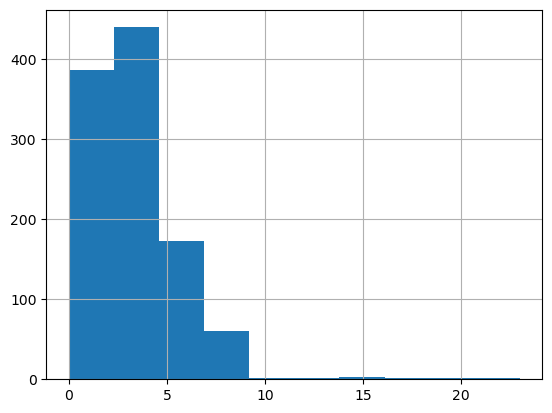

In [736]:
under_50 = train[train['pickup_count'] < 50]['hour']
under_50.hist() # When under 50 happens, per hour

In [737]:
train.groupby('hour')['pickup_count'].mean()

hour
0      76.035398
1      47.061947
2      31.261062
3      18.747788
4      16.672566
5      43.141593
6     143.371681
7     187.836283
8     183.769912
9     200.991150
10    198.278761
11    203.380531
12    208.460177
13    189.942478
14    191.252212
15    201.057522
16    183.920354
17    221.066372
18    233.690265
19    214.380531
20    184.907080
21    170.212389
22    150.977876
23    126.831858
Name: pickup_count, dtype: float64

<Axes: >

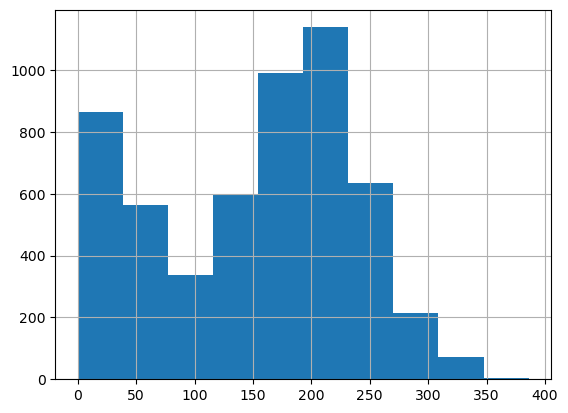

In [738]:
train['pickup_count'].hist()

<Axes: >

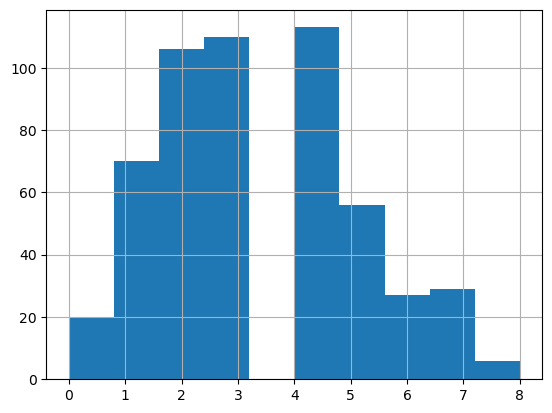

In [739]:
under_50_test = test[test['pickup_count'] < 50]['hour']
under_50_test.hist()

In [740]:
test.groupby('hour')['pickup_count'].mean()

hour
0      99.690265
1      49.115044
2      24.433628
3      15.654867
4      12.902655
5      45.221239
6      98.203540
7     151.035398
8     189.601770
9     207.584071
10    199.433628
11    205.654867
12    203.035398
13    204.159292
14    192.283186
15    191.601770
16    186.159292
17    217.778761
18    226.672566
19    201.796460
20    179.840708
21    210.106195
22    178.831858
23    141.061947
Name: pickup_count, dtype: float64

<Axes: >

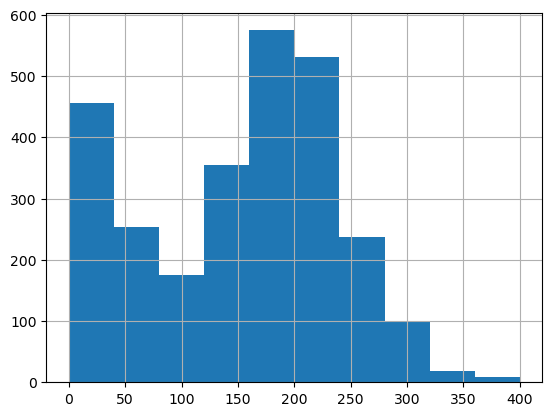

In [741]:
test['pickup_count'].hist()

## Plot general Time Series

## Over chosen time interval

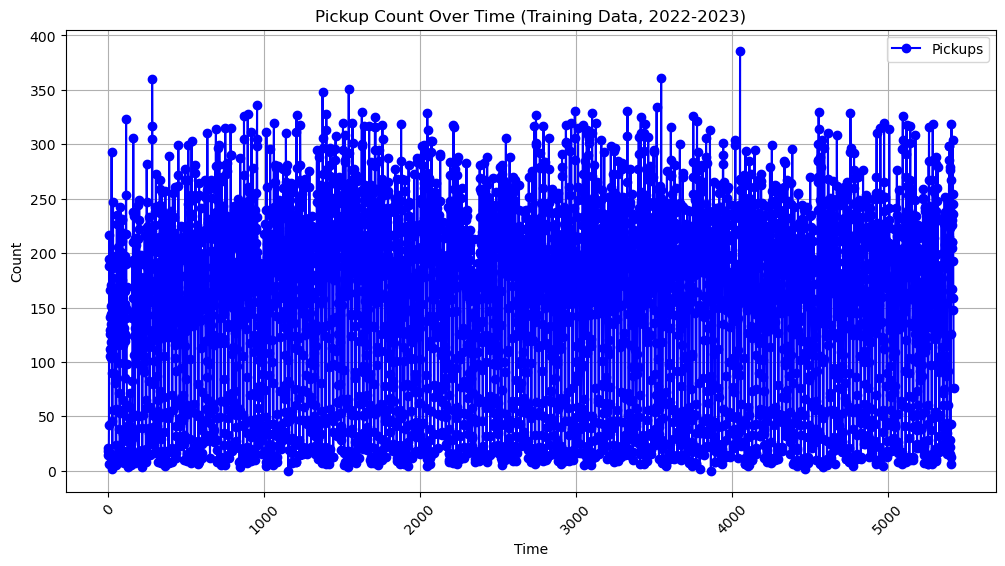

In [742]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'], train['pickup_count'], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, 2022-2023)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

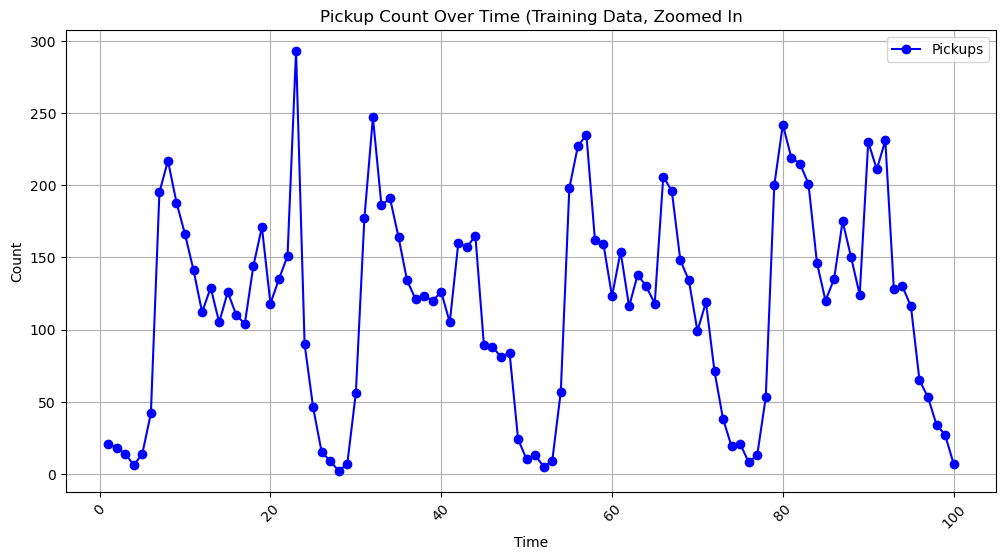

In [743]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'][:100], train['pickup_count'][:100], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, Zoomed In')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

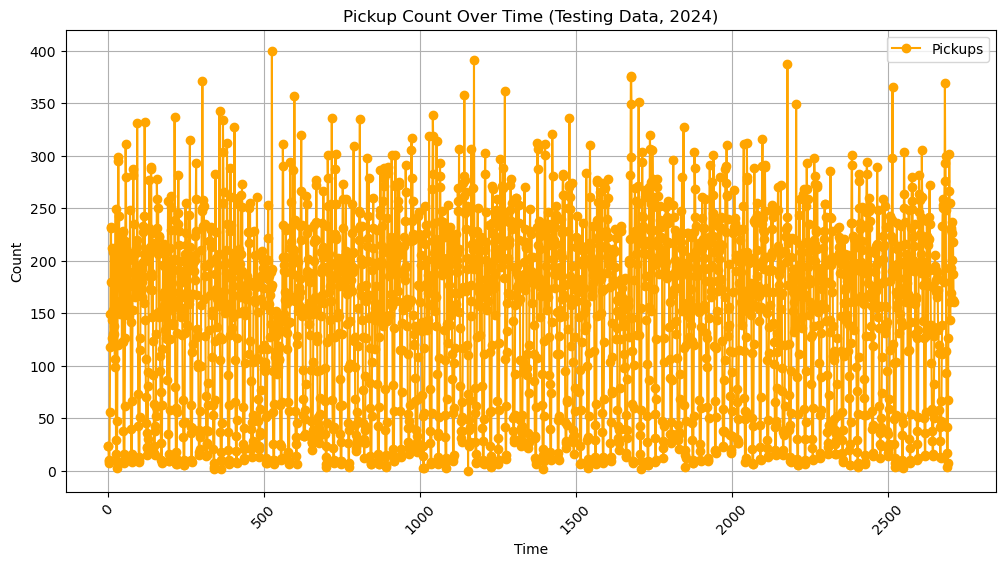

In [744]:
plt.figure(figsize=(12, 6))
plt.plot(test['time_index'], test['pickup_count'], marker='o', label='Pickups', color='orange')
plt.title('Pickup Count Over Time (Testing Data, 2024)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

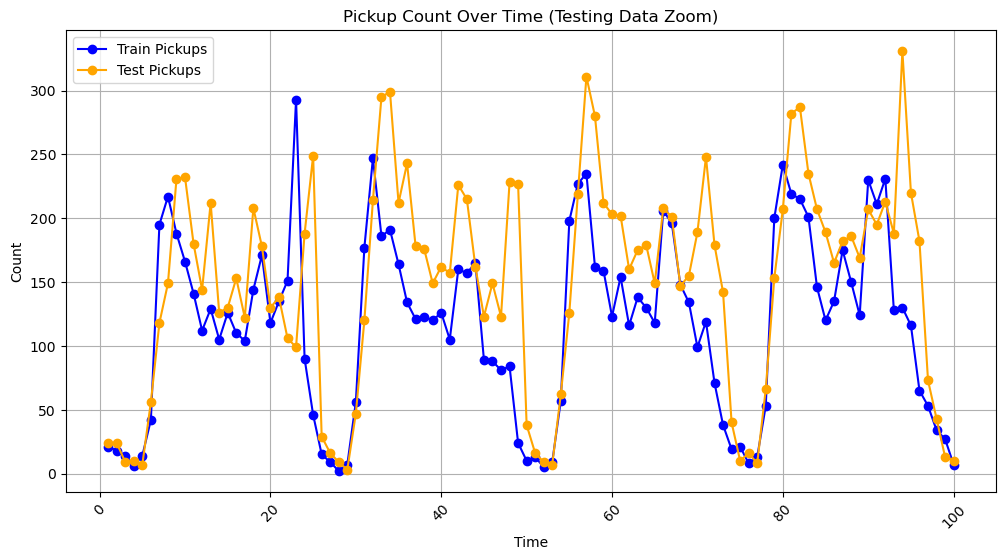

In [745]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'][:100], train['pickup_count'][:100], marker='o', label='Train Pickups', color='blue')
plt.plot(test['time_index'][:100], test['pickup_count'][:100], marker='o', label='Test Pickups', color='orange')
plt.title('Pickup Count Over Time (Testing Data Zoom)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## Over the hour

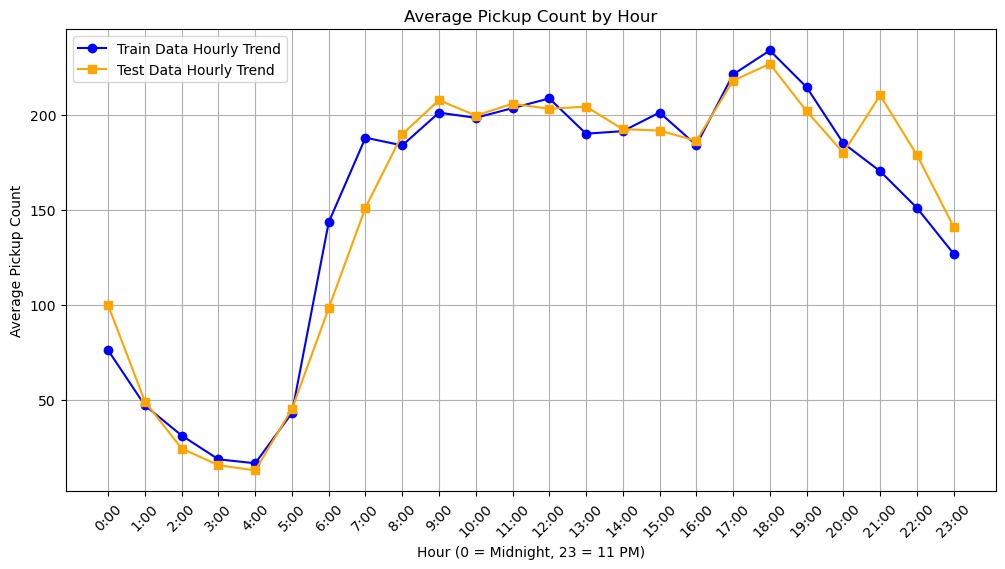

In [746]:
# Group by hour and calculate the mean pickup count for each hour
hourly_trend_train = train.groupby('hour')['pickup_count'].mean()
hourly_trend_test = test.groupby('hour')['pickup_count'].mean()

# Plot hourly trend
plt.figure(figsize=(12, 6))
plt.plot(
    hourly_trend_train.index,
    hourly_trend_train.values,
    marker='o',
    label='Train Data Hourly Trend',
    color='blue'
)
plt.plot(
    hourly_trend_test.index,
    hourly_trend_test.values,
    marker='s',
    label='Test Data Hourly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Hour')
plt.xlabel('Hour (0 = Midnight, 23 = 11 PM)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(0, 24),
    labels=[f'{h}:00' for h in range(0, 24)],  # Formats hour labels as '0:00', '1:00', etc.
    rotation=45
)
plt.grid()
plt.legend()
plt.show()

## Over each weekday

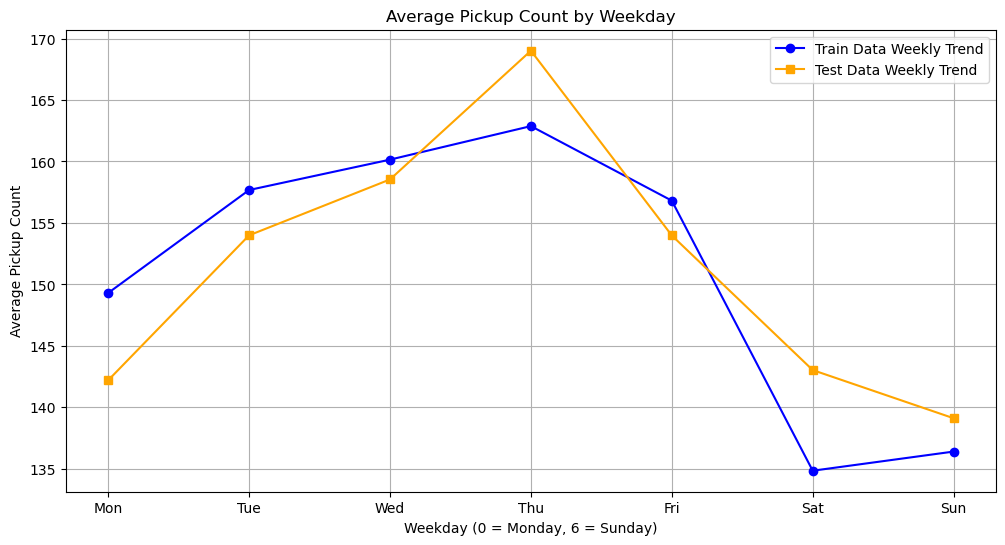

In [706]:
# Group by weekday and calculate the mean pickup count for each weekday
weekly_trend_train = train.groupby('weekday')['pickup_count'].mean()
weekly_trend_test = test.groupby('weekday')['pickup_count'].mean()

# Plot weekly trend
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_trend_train.index,
    weekly_trend_train.values,
    marker='o',
    label='Train Data Weekly Trend',
    color='blue'
)
plt.plot(
    weekly_trend_test.index,
    weekly_trend_test.values,
    marker='s',
    label='Test Data Weekly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Weekday')
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=weekly_trend_train.index,
    labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
plt.grid()
plt.legend()
plt.show()


## Over the weeks

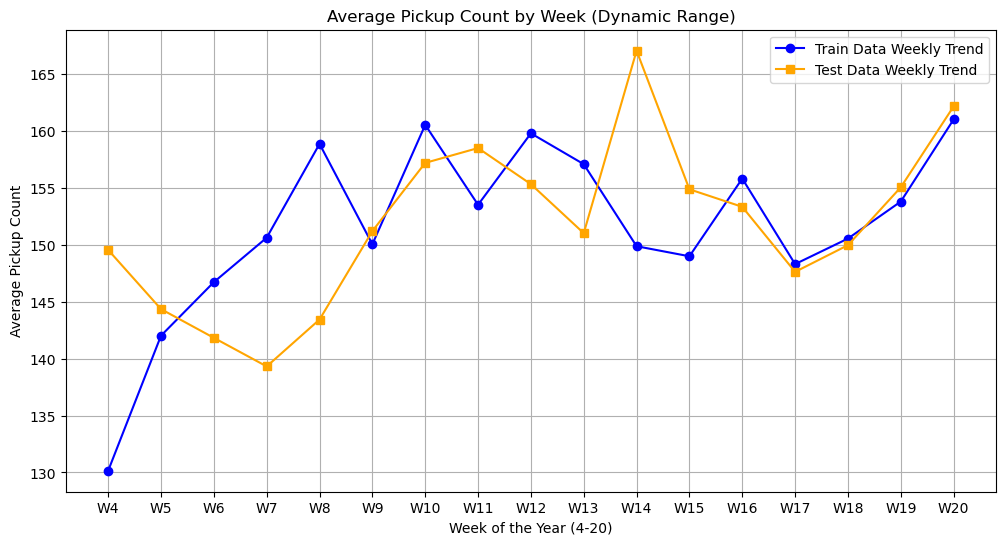

In [707]:
# Group by week of the year and calculate the mean pickup count for each week
train['pickup_time'] = pd.to_datetime(train['pickup_time'])
test['pickup_time'] = pd.to_datetime(test['pickup_time'])
train['week'] = train['pickup_time'].dt.isocalendar().week
test['week'] = test['pickup_time'].dt.isocalendar().week

# Determine the min and max week from both datasets
min_week = min(train['week'].min(), test['week'].min())
max_week = max(train['week'].max(), test['week'].max())

# Group by week for the range of weeks in the data
weekly_trend_train = train.groupby('week')['pickup_count'].mean()
weekly_trend_test = test.groupby('week')['pickup_count'].mean()

# Plot weekly trend
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_trend_train.index,
    weekly_trend_train.values,
    marker='o',
    label='Train Data Weekly Trend',
    color='blue'
)
plt.plot(
    weekly_trend_test.index,
    weekly_trend_test.values,
    marker='s',
    label='Test Data Weekly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Week (Dynamic Range)')
plt.xlabel(f'Week of the Year ({min_week}-{max_week})')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(min_week, max_week + 1, max(1, (max_week - min_week) // 10)),  # Adjust ticks dynamically
    labels=[f'W{k}' for k in range(min_week, max_week + 1, max(1, (max_week - min_week) // 10))]
)
plt.grid()
plt.legend()
plt.show()


## Over the month

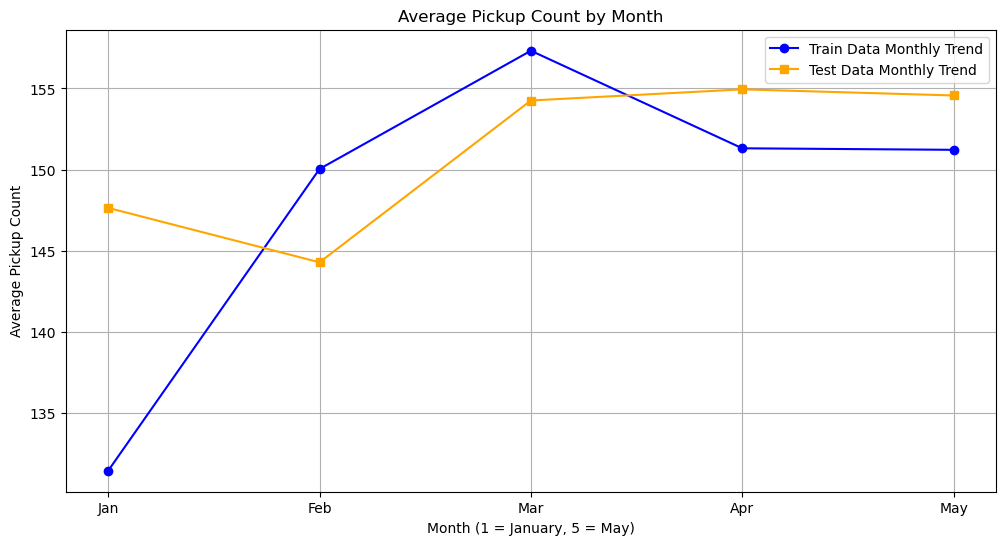

In [708]:
# Group by month and calculate the mean pickup count for each month
monthly_trend_train = train.groupby(train['pickup_time'].dt.month)['pickup_count'].mean()
monthly_trend_test = test.groupby(test['pickup_time'].dt.month)['pickup_count'].mean()

# Plot monthly trend
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_trend_train.index,
    monthly_trend_train.values,
    marker='o',
    label='Train Data Monthly Trend',
    color='blue'
)
plt.plot(
    monthly_trend_test.index,
    monthly_trend_test.values,
    marker='s',
    label='Test Data Monthly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Month')
plt.xlabel('Month (1 = January, 5 = May)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(1, 6),
    labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May'
    ]
)
plt.grid()
plt.legend()
plt.show()


## Model Fitting

In [490]:
# Features (X) - Including the new feature
X_train = train[['hour', 'weekday']].values
X_test = test[['hour', 'weekday']].values

# Features (X) - All columns except 'pickup_count'
#X_train = train[['hour']].values
#X_test = test[['hour']].values

# Target (y) - 'pickup_count'
# Subtract the mean function (use training data)
mean_func = train['pickup_count'].mean()
y_train = train['pickup_count'].values - mean_func
y_test = test['pickup_count'].values - mean_func

# Scale features if necessary (important for GP models to avoid dominance of larger scale features)
## HERE
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#print(X_scaled)

In [491]:
X_train

array([[0.        , 0.        ],
       [0.04347826, 0.        ],
       [0.08695652, 0.        ],
       ...,
       [0.91304348, 0.        ],
       [0.95652174, 0.        ],
       [1.        , 0.        ]])

In [492]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5424, 2), (5424,), (2712, 2), (2712,))

In [493]:
# Define the GP kernel
# - RBF for smooth trends
# - ExpSineSquared for periodicity
kernel = (
   C(30.0, (1e-1, 1e5))  # Constant term to scale the entire kernel
   * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))  # Squared exponential

    + C(50.0, (1e-1, 1e5))  # Constant term for cosine scaling
    * ExpSineSquared(length_scale=1.0, periodicity=8, periodicity_bounds=(1e-2, 1e2), length_scale_bounds=(1e-2, 1e2))  # Cosine
## These two above work

    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e5))
)

# Instantiate and fit the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=1e-5)
gp.fit(X_train, y_train)
print("Fit Complete")
print("Learned Kernel:", gp.kernel_)

# Make predictions (add mean back)
y_pred, sigma = gp.predict(X_test, return_std=True)

KeyboardInterrupt: 

Root Mean Squared Error: 66.076
R^2 Score: 0.834


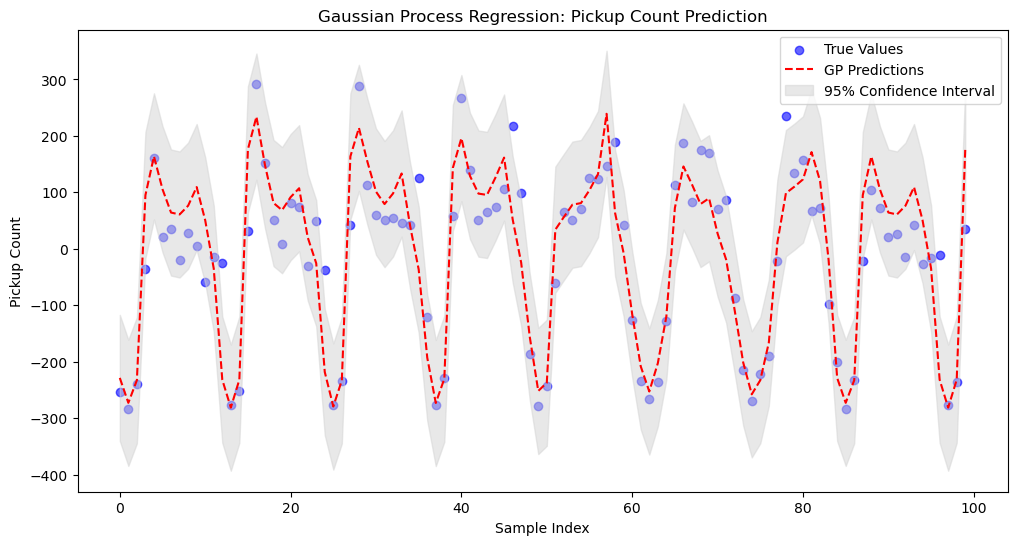

In [ ]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction")
plt.legend()
plt.show()

In [ ]:
sigma.mean() * 1.96

np.float64(111.73616895506272)

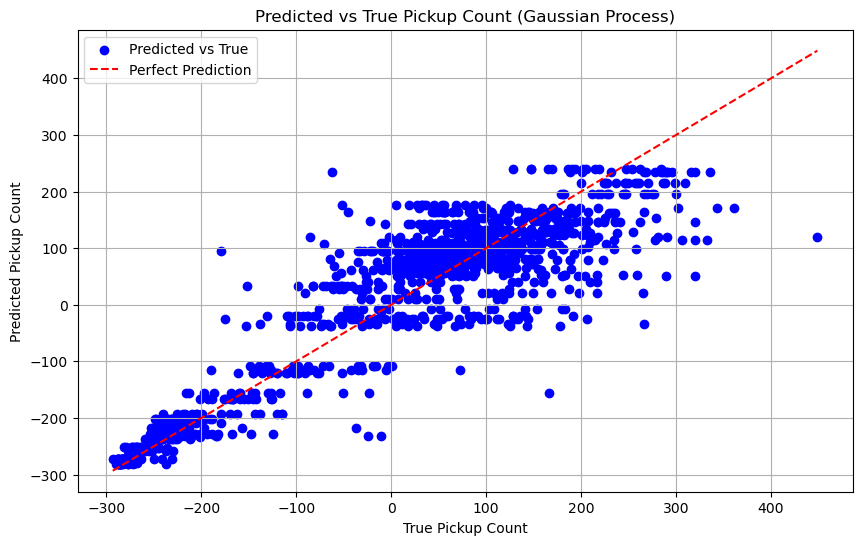

In [ ]:
# Prediction vs True Values plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True Pickup Count')
plt.ylabel('Predicted Pickup Count')
plt.title('Predicted vs True Pickup Count (Gaussian Process)')
plt.legend()
plt.grid(True)
plt.show()

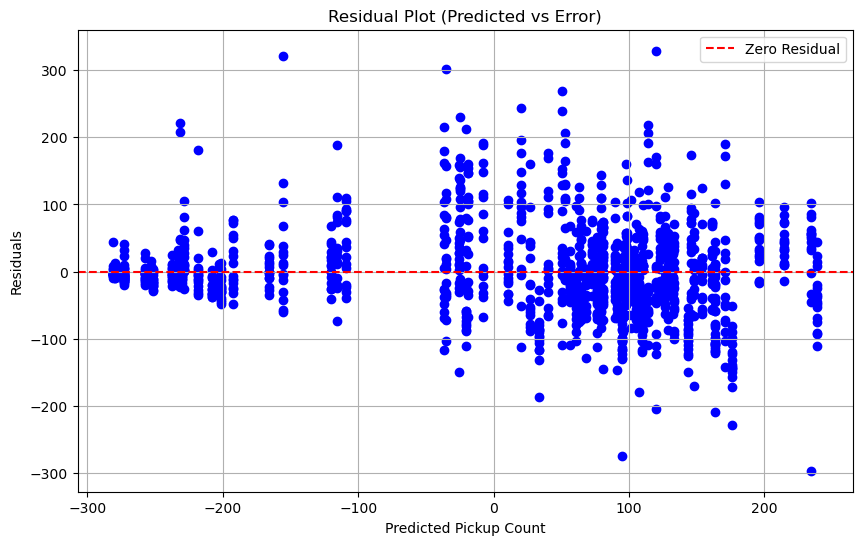

In [ ]:
# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# R²
r2 = r2_score(y_test, y_pred)
print("R²:", r2)


RMSE: 66.0758183811038
R²: 0.8342269407978458


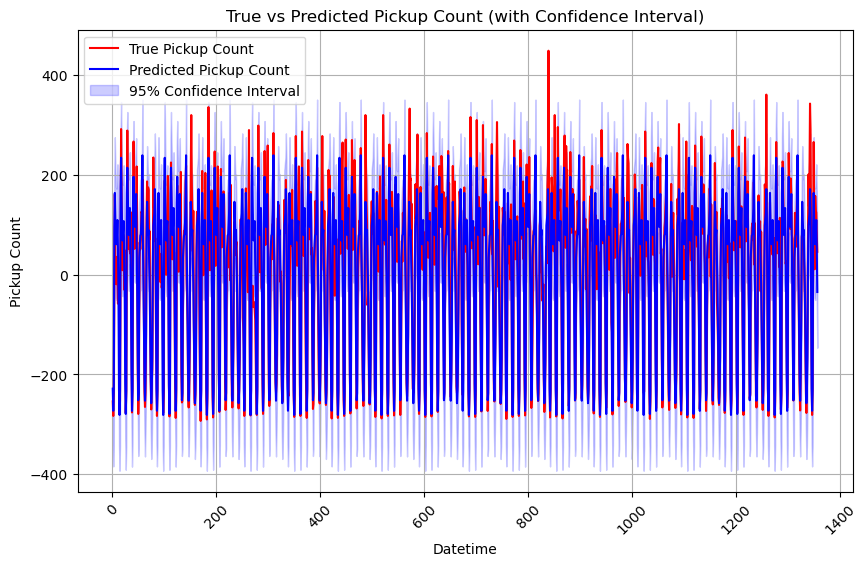

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test['time_index'], y_test, label='True Pickup Count', color='red')
plt.plot(test['time_index'], y_pred, label='Predicted Pickup Count', color='blue')
plt.fill_between(test['time_index'], y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Datetime')
plt.ylabel('Pickup Count')
plt.title('True vs Predicted Pickup Count (with Confidence Interval)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()